In [1]:
import giraffe
import matplotlib.pyplot as plt
from netZooPy.otter.otter import otter
from netZooPy.panda import Panda
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import torch
from sklearn.preprocessing import normalize

In [2]:
expression = pd.read_csv("yeast/expression/TFKOexpressionData.csv", index_col = 0)
prior = pd.read_csv("yeast/prior/S8_50-TF_ChIP-PC_binary_network_with_signs_from_ZEV.csv", index_col = 0).T
ppi = pd.read_csv("yeast/ppi.txt", index_col = 0)

In [3]:
def get_data(norm=False):
    tf = []
    for p in prior.index:
        if p in ppi.index:
            tf.append(p)
    M = prior.T.loc[:, list(set(tf))]
    E = expression.loc[expression.index.isin(M.index), list(set(tf))]
    full_E = expression.loc[expression.index.isin(M.index), :]
    if norm:
        full_E = pd.DataFrame(normalize(full_E, "l1"), index = E.index, columns = expression.columns)
    P = ppi.loc[list(set(tf)), list(set(tf))]

    E.sort_index(axis = 1, inplace = True)
    full_E.sort_index(axis=1, inplace=True)
    full_E.sort_index(axis=0, inplace=True)
    M.sort_index(axis = 1, inplace = True)
    P.sort_index(axis = 0, inplace = True)
    P.sort_index(axis = 1, inplace = True)
    return E, full_E, M, P, tf

In [4]:
def get_gt(expr, full_expr, shape, tf_names):
    D = np.zeros(shape)
    for i, tf in enumerate(tf_names):
        treat = full_expr.loc[:, tf]
        control = np.mean(expr.iloc[:, [j for j in range(expr.shape[1]) if expr.columns[j] != tf]], axis=1)
        D[:, i] = treat - control
    return normalize(D, "l2")

In [5]:
def plot(D, R, method):
    products = [xi * yi for xi, yi in zip(list(D.flatten()), list(R.flatten()))]
    colors = ['r' if prod > 0 else 'g' for prod in products]
    plt.scatter(D.flatten(), R.flatten(), c=colors)
    score = np.sum((D > 0) == (R < 0)) / (R.shape[0] * R.shape[1])
    plt.title(f"{method}, accuracy {score.round(2)}")
    plt.xlabel("Normalized difference between intervention and control")
    plt.ylabel("Edge weight")

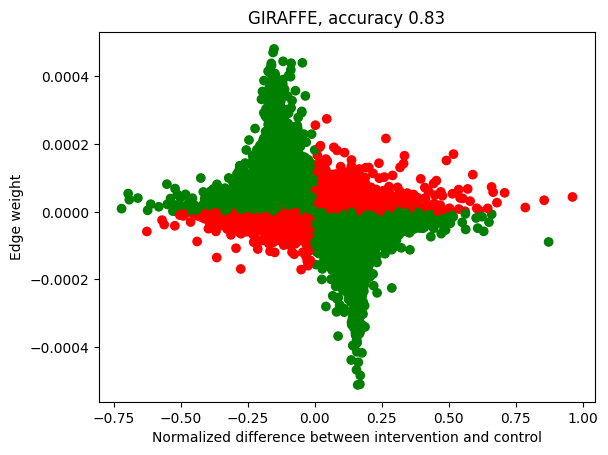

In [7]:
E, full_E, M, P, _ = get_data(norm=True)
model = giraffe.Giraffe(E, abs(M.to_numpy()), P + np.eye(P.shape[0]), min_iter=10000, max_iter=20000)
R = model.get_regulation()
D = get_gt(E, full_E, R.shape, P.columns)

plot(D, R, "GIRAFFE")
plt.savefig('giraffe_sign_accuracy.png') 

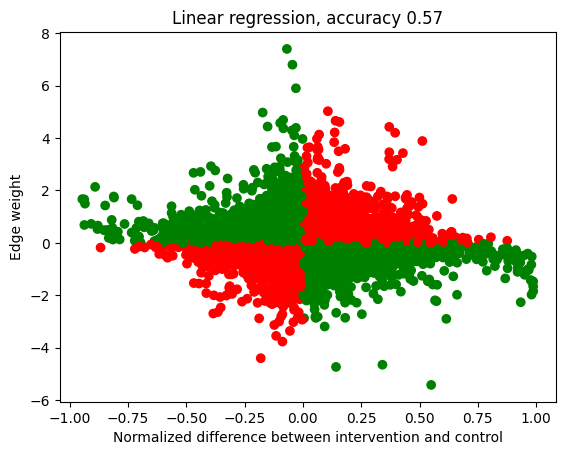

In [9]:
from sklearn.linear_model import LinearRegression

E, full_E, M, P, tf = get_data()
D = get_gt(E, full_E, M.shape, P.columns)

X = np.zeros((E.shape[1], P.shape[0]))
for i, t in enumerate(P.columns):
    X[:, i] = expression.loc[t, list(set(tf))]
R = np.zeros(M.shape)
for i in range(R.shape[0]):
    Y = expression.loc[M.index[i], list(set(tf))]
    reg = LinearRegression().fit(X, Y)
    R[i, :] = reg.coef_

plot(D, R, "Linear regression")
plt.savefig('lm_sign_accuracy.png') 

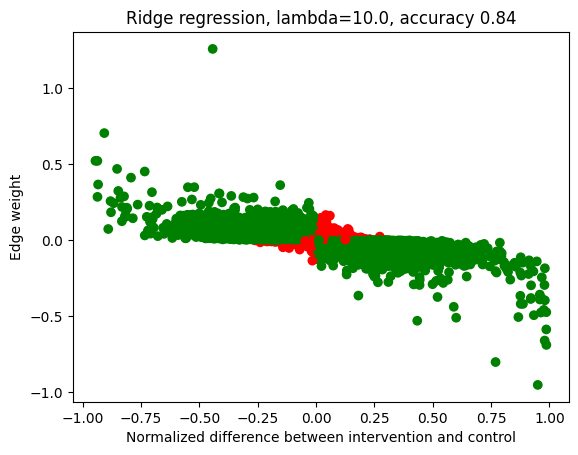

In [10]:
from sklearn.linear_model import RidgeCV

E, full_E, M, P, tf = get_data()
D = get_gt(E, full_E, M.shape, P.columns)

X = np.zeros((E.shape[1], P.shape[0]))
for i, t in enumerate(P.columns):
    X[:, i] = expression.loc[t, list(set(tf))]
R = np.zeros(M.shape)
for i in range(R.shape[0]):
    Y = expression.loc[M.index[i], list(set(tf))]
    reg = reg = RidgeCV(alphas=np.linspace(1e-10, 10, 100)).fit(X, Y)
    R[i, :] = reg.coef_

plot(D, R, f"Ridge regression, lambda={reg.alpha_.round(2)}")
plt.savefig('ridge_sign_accuracy.pdf') 